# Project 2
Dieter Brehm and Corinne Wilklow - Project 2 - Fall 2018  
A project examining the relationship and lag time between inner and outer temperatures of a house, and how insulation can be optimized for climate.

In [487]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

## Question: How much insulation of what type should be installed in a house to maintain a chosen comfortable temperature over the course of eighty hours in a house in London? Additionally, what is an accessible way to visualize these insulation design decisions?

When building a house, the person building it has to decide on what type and thickness of insulation to include in the house. The solution to this problem varies greatly with the location of the house.

When visiting online stores and suppliers of insulation, we found that they provided a standard "R value" rating per inch of a given insulation that was sold. However, it was difficult to find any visualization of this rating that a non-expert could understand easily. We decided that it could be useful to produce a model that is able to give a rough approximation of temperature curves over time to help people decide what insulation would be best to use.

By further tuning this model, it could be customized to other regions and help homeowners choose an insulation and visualize their insulation scenario. We give a rough example of this tuning in the validation section.

## Model:
We started by importing a selection of R values for commercially available insulation
into a dataframe, which we will later use as input for a sweep of temperature simulations.

In [488]:
R_data = pd.read_csv('r_values.csv', header=0, index_col=0, usecols=range(1,2))

""
R
1.25
3.71
3.85
4.00
4.13
4.29
5.00
5.00
6.50


Next, we imported the exterior temperature data from a study that examines
the characteristics of a wall in London. We are only concerned with the T_ext column of this data as a convenient dataset for exterior temperature over a few days in London.

The paper used here is Gori, Marincioni, Biddulph, Elwell, "Inferring the thermal resistance and effective thermal mass distribution of a wall from in situ measurements to characterise heat transfer at both the interior and exterior surfaces", *Energy and Buildings*, Volume 135, 15 January 2017, Pages 398-409. [It can be downloaded here](https://www.sciencedirect.com/science/article/pii/S0378778816313056).

In [489]:
# Load dataset values
ext_data = pd.read_csv('DataOWall.csv', parse_dates=[0],
                        index_col=0, header=0, skiprows=[1,2])
ext_data.head()

,Q_in,Q_out,T_int,T_ext
2014-10-05 16:30:00,10.994,6.840,16.92,14.68
2014-10-05 16:35:00,10.952,6.012,16.92,14.69
2014-10-05 16:40:00,10.882,7.040,16.93,14.66
2014-10-05 16:45:00,10.798,8.880,16.93,14.59
2014-10-05 16:50:00,10.756,10.491,16.94,14.50


The data was imported with timestamps that are not very useful for us. In order to easily match our equations, we converted these timestamps to hours.


In [490]:
# Convert Index entries to seconds, noticing the spacing between recordings
timestamp_0 = get_first_label(ext_data)
time_deltas = ext_data.index - timestamp_0;

ext_data.index = time_deltas.days * 86400 + time_deltas.seconds

In [491]:
# convert index entries to hours
ext_data.T_ext.head()
T_ext_external = ext_data.T_ext
for i, v in ext_data.T_ext.items():
    scaled = i / 3600
    T_ext_external = T_ext_external.rename(index={i: scaled})

T_ext_external.head()

0.000000    14.68
0.083333    14.69
0.166667    14.66
0.250000    14.59
0.333333    14.50
Name: T_ext, dtype: float64

Here, we plotted the temperature versus time of this data for T_ext. The highs and lows as days progress are clear in the plot.

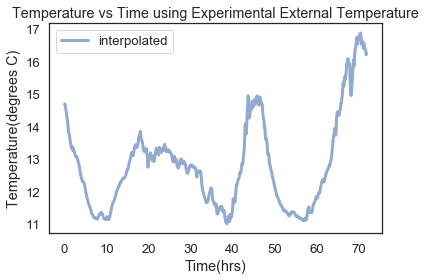

In [492]:
# plot the exterior temp data on top of the interpolation of the data
t_ext_func = interpolate(T_ext_external)
plot(T_ext_external.index, t_ext_func(T_ext_external.index), label="interpolated")
legend()
decorate(title = 'Temperature vs Time using Experimental External Temperature',
         xlabel = 'Time(hrs)',
         ylabel = 'Temperature(degrees C)')

In our system we made many assumptions about the exact specifications of our house. The dimensions of the house are adjustable, but the model is only built for rectangular prisms. We also created a house in which the floor, ceiling, and walls are all made of the same insulation.  
  
We set dt to be half an hour, assuming that there is no change in temperature over each step. In order to adapt the outside temperature data from OWall to fit this time step, we converted the timestamps to hours and used the interpolate function to estimate intermediate values in the data.  
  
When we chose an assortment of R values, we used the R value that corresponds to one inch of each material. When you stack insulation together, their R values simply add. By using one inch of every material, we can easily calculate the R value of increased depths of insulation if necessary.


In [493]:
def make_system(params):
    """Make a system object for insulation model.
    
    params object should contain
    T_ext: the starting exterior temperature
    T_int: the starting interior tempature
    R: the R-rating of the insulation, in units ft^2*deg5/btu/hr/in
    d: the depth of the insulation, in units inches
    l: house length in meters
    w: house width in meters
    h: house height in meters
    c: c value of air for Newton's law of cooling, in units btu/lbm*R
    
    returns: System
    """
    T_int, T_ext, R, d, l, w, h, c = params
                
    # density of air
    rho = 1

    # m/s^2, acceleration due to gravity
    g = 9.8 
    
    # air volume inside house m^3
    V = l * w * h

    # mass of air in room in lb
    m = (rho * V * g) * 2.2 
                
    # calculate surface area, and convert from m^2 to ft^2
    SA = (l * w * 4 + h * l * 2) * 10.7639

    first = State(T_int=T_int, T_ext=T_ext)
    
    # time constants
    t0 = 0
    t_end = 80
    dt = .5

    return System(init=first, t0=t0, t_end=t_end, dt=dt, R=R, d=d,
                  SA=SA, m=m, c=c)

In [494]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.

    system: System object
    update_func: function that updates state
    
    returns: TimeFrame
    """
    frame = TimeFrame(columns=system.init.index)
    frame.row[system.t0] = system.init
    
    for t in linrange(system.t0, system.t_end,system.dt):
        frame.row[t+system.dt] = update_func(frame.row[t], t, system)
    
    return frame

We assumed that all heat flows directly out of the house. This allows our model to quantify all temperature loss during a given time frame. We allowed outside temperature to influence inside temperature, but we did not allow heat flow to the outside to influence the outside temperature. This assumption makes sense when analyzing a free-standing structure, but it would not make sense on a densely packed city block.
  
We also assumed that heat flows evenly through all sides of the house, again an assumption that would work for a free-standing house, but not a series of row houses. Embedded in this assumption is the idea that outside temperature is equal at every point around the house. We didn’t take into account sun or shade surrounding the house, or that the ground might be an entirely different temperature than the air. This causes our model to be simplistic, but it could be iterated into a model that incorporates the difference between air and ground temperature.  

In [495]:
def update_func(state, t, system):
    """Update the model.
    
    state: State with variables T_int, T_ext
    dt: time step
    system: System
    
    returns: State object
    """
    
    T_int, T_ext = state
    
    # use the dataset values by overwritting state value
    T_ext = t_ext_func(t) * 9 / 5 + 32
    
    delta_T = T_int - T_ext
    
    dQ = (system.SA * delta_T / (system.R * system.d)) * system.dt
   
    if system.c == 0:
        system.c = dQ / delta_T
      
    dT = dQ / (system.c * system.m) 
    
    T_int = T_int - dT
    
    return State(T_int = T_int, T_ext = T_ext)

In order to better visualize our model, we also wrote an update function which does not consider exterior temperature data which can be used for testing and validation of the basis of our model.

In [496]:
def update_func_isolated(state, t, system):
    """Update the model.
    
    state: State with variables T_int, T_ext
    dt: time step
    system: System
    
    returns: State object
    """
    
    T_int, T_ext = state
    
    # find the difference between interior and exterior temp
    delta_T = T_int - T_ext
    
    # our differential equation for heat transfer through conduction
    dQ = (system.SA * delta_T / (system.R * system.d)) * system.dt
    
    # converting heat transfer to interior temperature change
    # using the definition of heat from the ModSimPy Textbook
    dT = dQ / (system.c * system.m) 
    
    T_int = T_int - dT
    
    return State(T_int = T_int, T_ext = T_ext)

The following plot is of a test run of the simulation which includes only one R value of 3 to see if the results look reasonable. Knowing that an isolated R value of 3 with an insulation depth of four inches should follow the exterior curve quite closely, this looks pretty reasonable. Also included is a plot of internal temperature versus time with constant external temperature to show the characteristics of our equation.

In [497]:
params = Params(T_int = 60,
                T_ext = 47,
                R = 3,
                d = 4,
                l = 6,
                w = 6,
                h = 6,
                c = 0.171)
                
system = make_system(params);

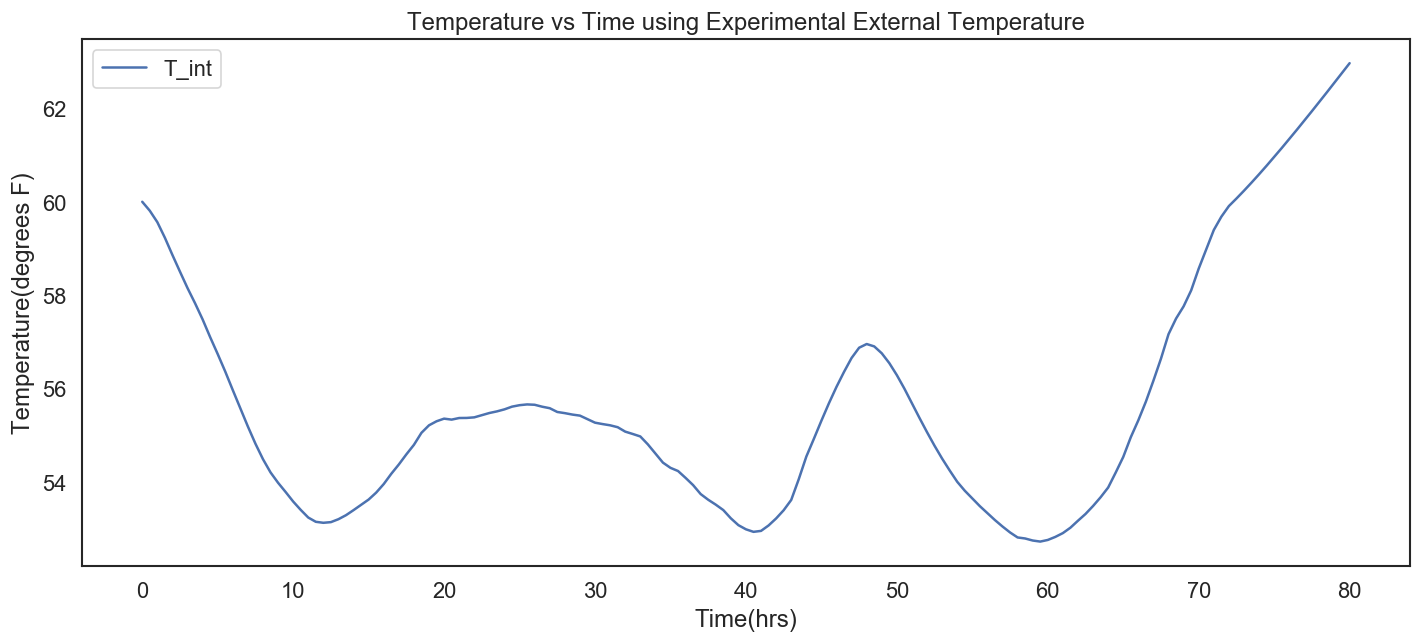

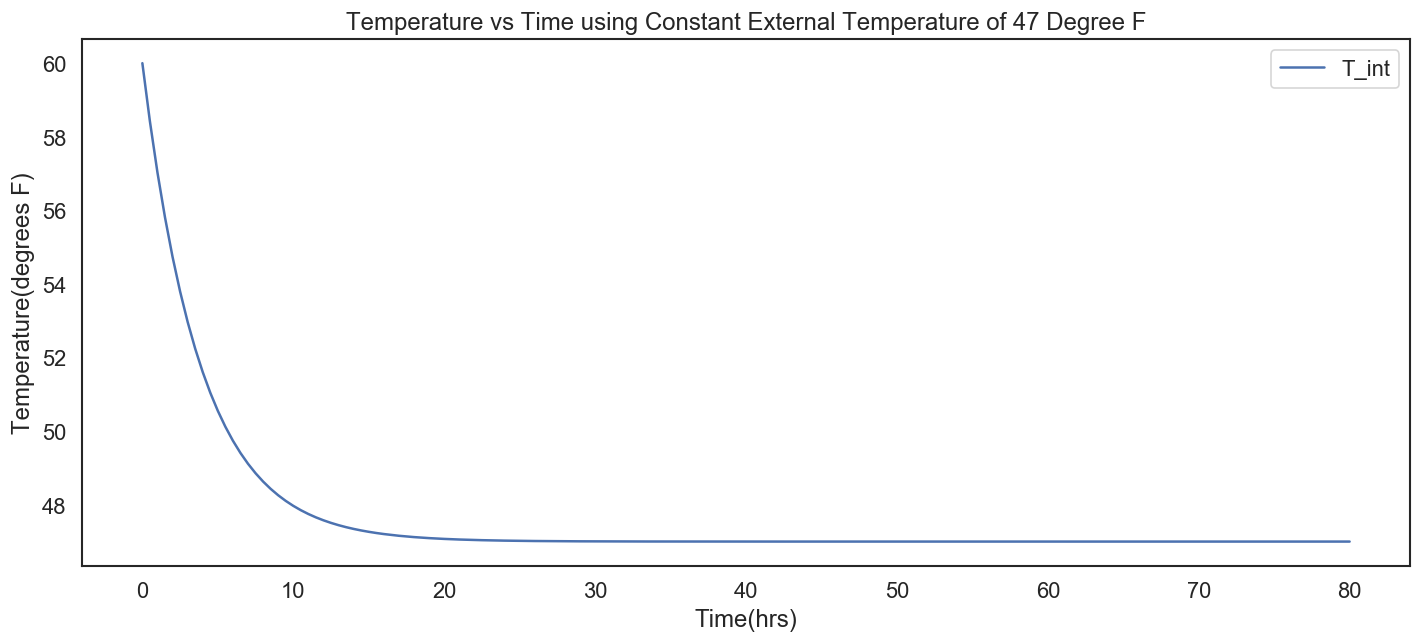

In [498]:
# test the simulation with the r value set in params
results = run_simulation(system, update_func)
results_const = run_simulation(system, update_func_isolated)

# plot decoration
fig1 = plt.figure(figsize=(12, 10), dpi=120,)
ax1 = fig1.add_subplot(211)    
ax1.plot(results.T_int)
decorate(title = 'Temperature vs Time using Experimental External Temperature',
         xlabel = 'Time(hrs)',
         ylabel = 'Temperature(degrees F)')

fig2 = plt.figure(figsize=(12, 10), dpi=120,)
ax1 = fig2.add_subplot(211)    
ax1.plot(results_const.T_int)
decorate(title = 'Temperature vs Time using Constant External'
         + ' Temperature of 47 Degree F',
         xlabel = 'Time(hrs)',
         ylabel = 'Temperature(degrees F)')

## Results:

###  Validation

The plot below is of a test run of the simulation which we compared to a different paper's experimental data of exterior and interior temperature of a house in California versus time to see if the results look reasonable. In the paper, they warmed the house up to 70 degrees Fahrenheit and then let the interior temperature decay over time, measuring the temperature values. We tuned the system parameters to match those indicated in the paper as much as possible. Looking at the curves of the two plots, our own and the one from the article, the results look reasonable.

The paper used for validation is J.E. Janssen, A.N. Pearman, "Comparison of BTR Measurements", from the Thermal Performance of the Exterior Envelopes of Whole Buildings XIII International Conference. [It can be downloaded here](https://web.ornl.gov/sci/buildings/conf-archive/1979%20B1%20papers/017.pdf).

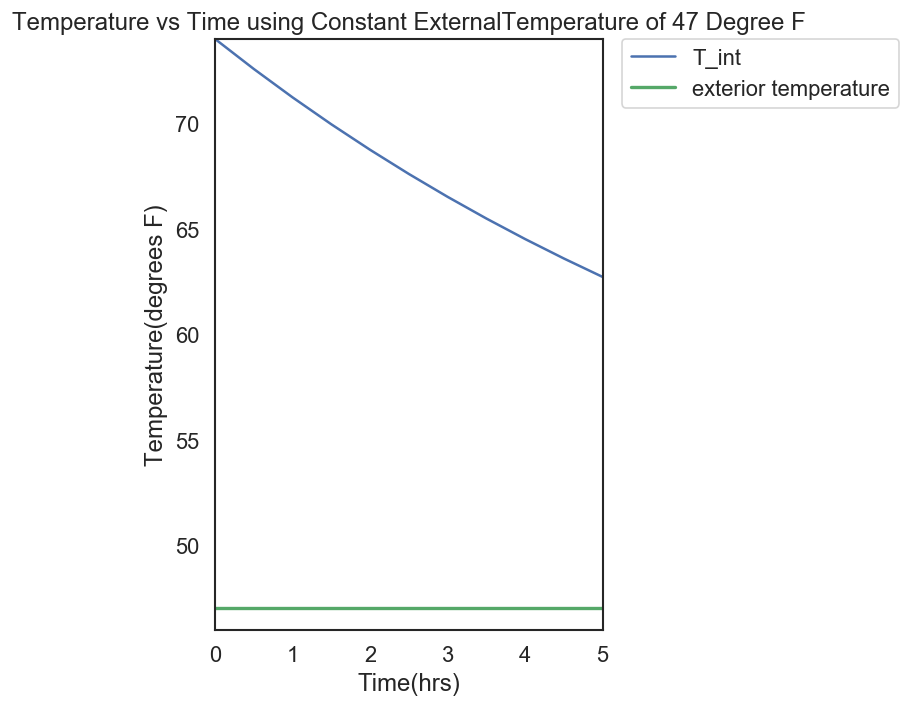

In [499]:
# change params for house size, insulation type, and temperatures
# given in the BTR Measurement paper
params = Params(T_int = 74,
                T_ext = 47,
                R = 3.3,
                d = 6,
                l = 9.8,
                w = 14,
                h = 7,
                c = 0.171)
                
system = make_system(params)

# run the simulation with the new params and an
# update function that doesn't consider an experimental
# exterior temperature
results = run_simulation(system, update_func_isolated)

fig1 = plt.figure(figsize=(10, 6), dpi=120,)
ax1 = fig1.add_subplot(121)    
ax1.plot(results.T_int)
plt.xlim(0, 300/60)
plt.ylim(46, 74)
ax1.plot([0, 14], [47, 47], color='g', linestyle='-',
         linewidth=2, label="exterior temperature")

# Line breaks at strange locations like this are used to make
# the pdf output prettier
decorate(title = 'Temperature vs Time using Constant External'
         + 'Temperature of 47 Degree F',
         xlabel = 'Time(hrs)',
         ylabel = 'Temperature(degrees F)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()


Below is the curve given by the paper. It is important to note the discontinuity of the axis of the paper's plot between 48 and 64 degrees Fahrenheit.
![title](validation.PNG)

Then, we composed a function that runs the simulation for all of the commercially-available R values we recorded and overlays the results on the same plot along with the exterior temperature data for comparison. We are using our intuition to say that 55 degrees Fahrenheit is a pretty comfortable temperature for the inside of a house to be. In this case, there was not an insulation type for which four inches would provide adequate insulation

In [500]:
def sweep_R(R_data):
    """
    Sweep a range of values of R and plot them
    R_data: list of r values
    
    returns: matplotlib figure
    """
    
    # names of the commercially available insulations, index of this list 
    # matches that of r-val csv
    insulation = ['plywood','EcoTouch','R-tech','Kingspan','Comfortbatt gold',
                  'Comfortbatt blue', 'Foamular','SilveRboard','Super TUFF',
                  'polyisocyanurate (foil-faced)', 'miracle material']
    
    fig1 = plt.figure(figsize=(18, 16), dpi=180)
    ax1 = fig1.add_subplot(211)
    
    for R in R_data.index.values:
        # change our R to the one in this loop of the sweep
        params[2] = R
        systemr = make_system(params)
        results = run_simulation(systemr, update_func)
        
        # match up insulation name with R value
        # display both together in the legend
        location = np.where(R_data.index == R)
        location = location[0].tolist()
        ax1.plot(results.T_int, label=str(R)
                 + ' times ' + str(systemr.d)
                 + ' inches of ' + insulation[location[0]])
 
    ax1.plot(results.T_int.index,
             t_ext_func(results.T_int.index)  * 9 / 5 + 32,
             label="interpolated exterior data")
    
    ax1.plot([0, 80], [55, 55], color='k', linestyle='-', linewidth=2,
             label="minimum acceptable interior temperature")
    
    decorate(title = 'Temperature vs Time using Experimental' 
             + ' External Temperature',
            xlabel = 'Time(hrs)',
            ylabel = 'Temperature(degrees F)')
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.legend(bbox_to_anchor=(0, 1.06, 1., .102), loc=3, 
               mode="expand", borderaxespad=0.)
    fig1.show()
    
    return fig1

C:\Miniconda3\lib\site-packages\matplotlib\figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


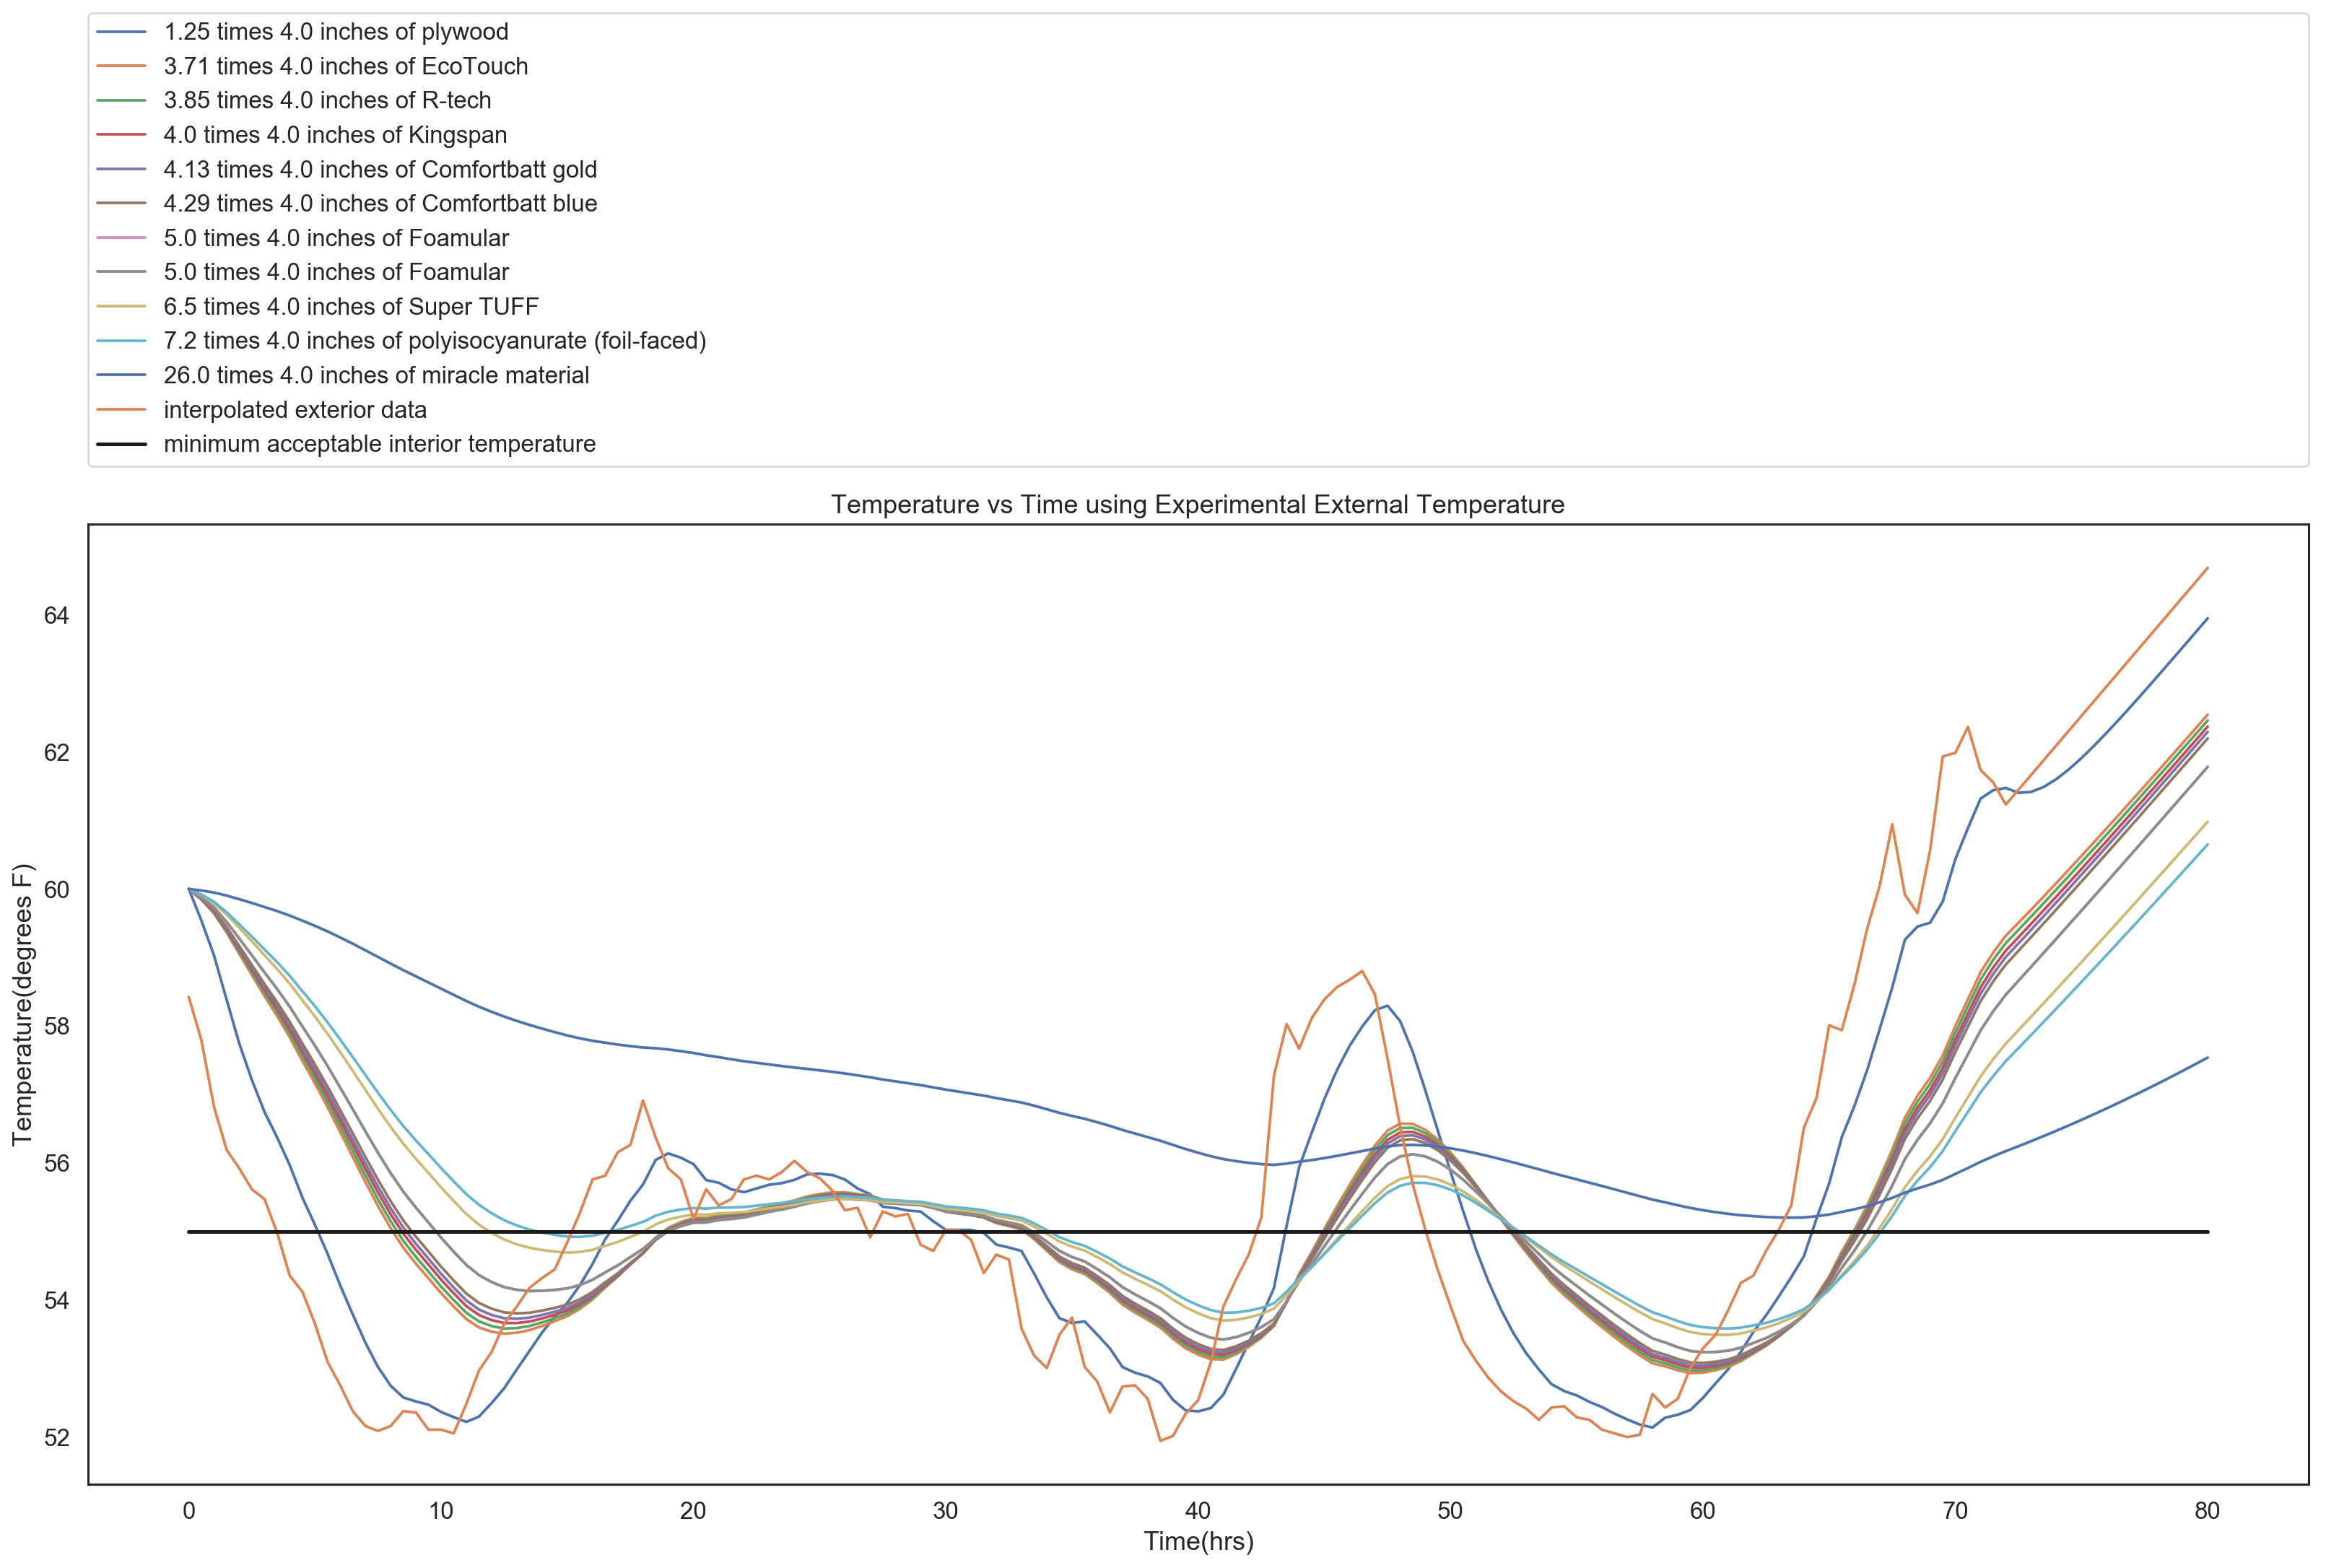

In [515]:
params = Params(T_int = 60,
                T_ext = get_first_value(ext_data.T_ext)*9/5+32,
                R = 3,
                d = 4,
                l = 6,
                w = 6,
                h = 6, 
                c = 0.171)

fig_sweep = sweep_R(R_data);

## Interpretation:

As evidenced by our plot, no one insulation would keep the temperature of the house from falling below the cutoff temperature of 55 degrees Fahrenheit for the entire run of the simulation. Realistically though, not many people would have only four inches of insulation in the exterior walls of their house in northern climates and a heating system that only ran once over the course of 80 hours. In our model we added a “Miracle Material” with an R value of 26, to demonstrate how that high of an R value would affect its reaction to the outside temperature. As it turns out, 26 is the perfect R to keep the house temperature always above the cutoff temperature.

The next step in the project would be to add the rest of walls, like plywood and drywall, to the R values of the insulation, to more accurately  model a wall. This wouldn’t change the results of the model by very much, but it would do away with some of the assumptions. We could also split the house into different segments, as walls are typically constructed differently than roofs and floors.
  
Another next step would be to figure out exactly how much of each insulation would be required to create an R value of 26, and, ultimately, our model seems to say that the type of insulation would matter less than the overall depth of the wall. It feels obvious that the higher the R value, the more it stabilizes the temperature. A deeper wall, then, would naturally be more insulating than a thinner wall, but from here we could add in a optimization function to optimize wall depth based on cost of materials. One additional question to explore is whether using more of a cheaper
insulation would be cheaper than less of a more expensive one given a particular climate.





## Abstract

We answered the question of how much insulation of what type should be installed in a house heated initially to 60 degrees Fahrenheit to maintain a chosen comfortable temperature of 55 degrees over the course of eighty hours in a house in London. The answer was that there must be an insulation with an R value of at least 26 and a depth of 4 inches to maintain a temperature above 55 degrees Fahrenheit for the eighty hour period. 

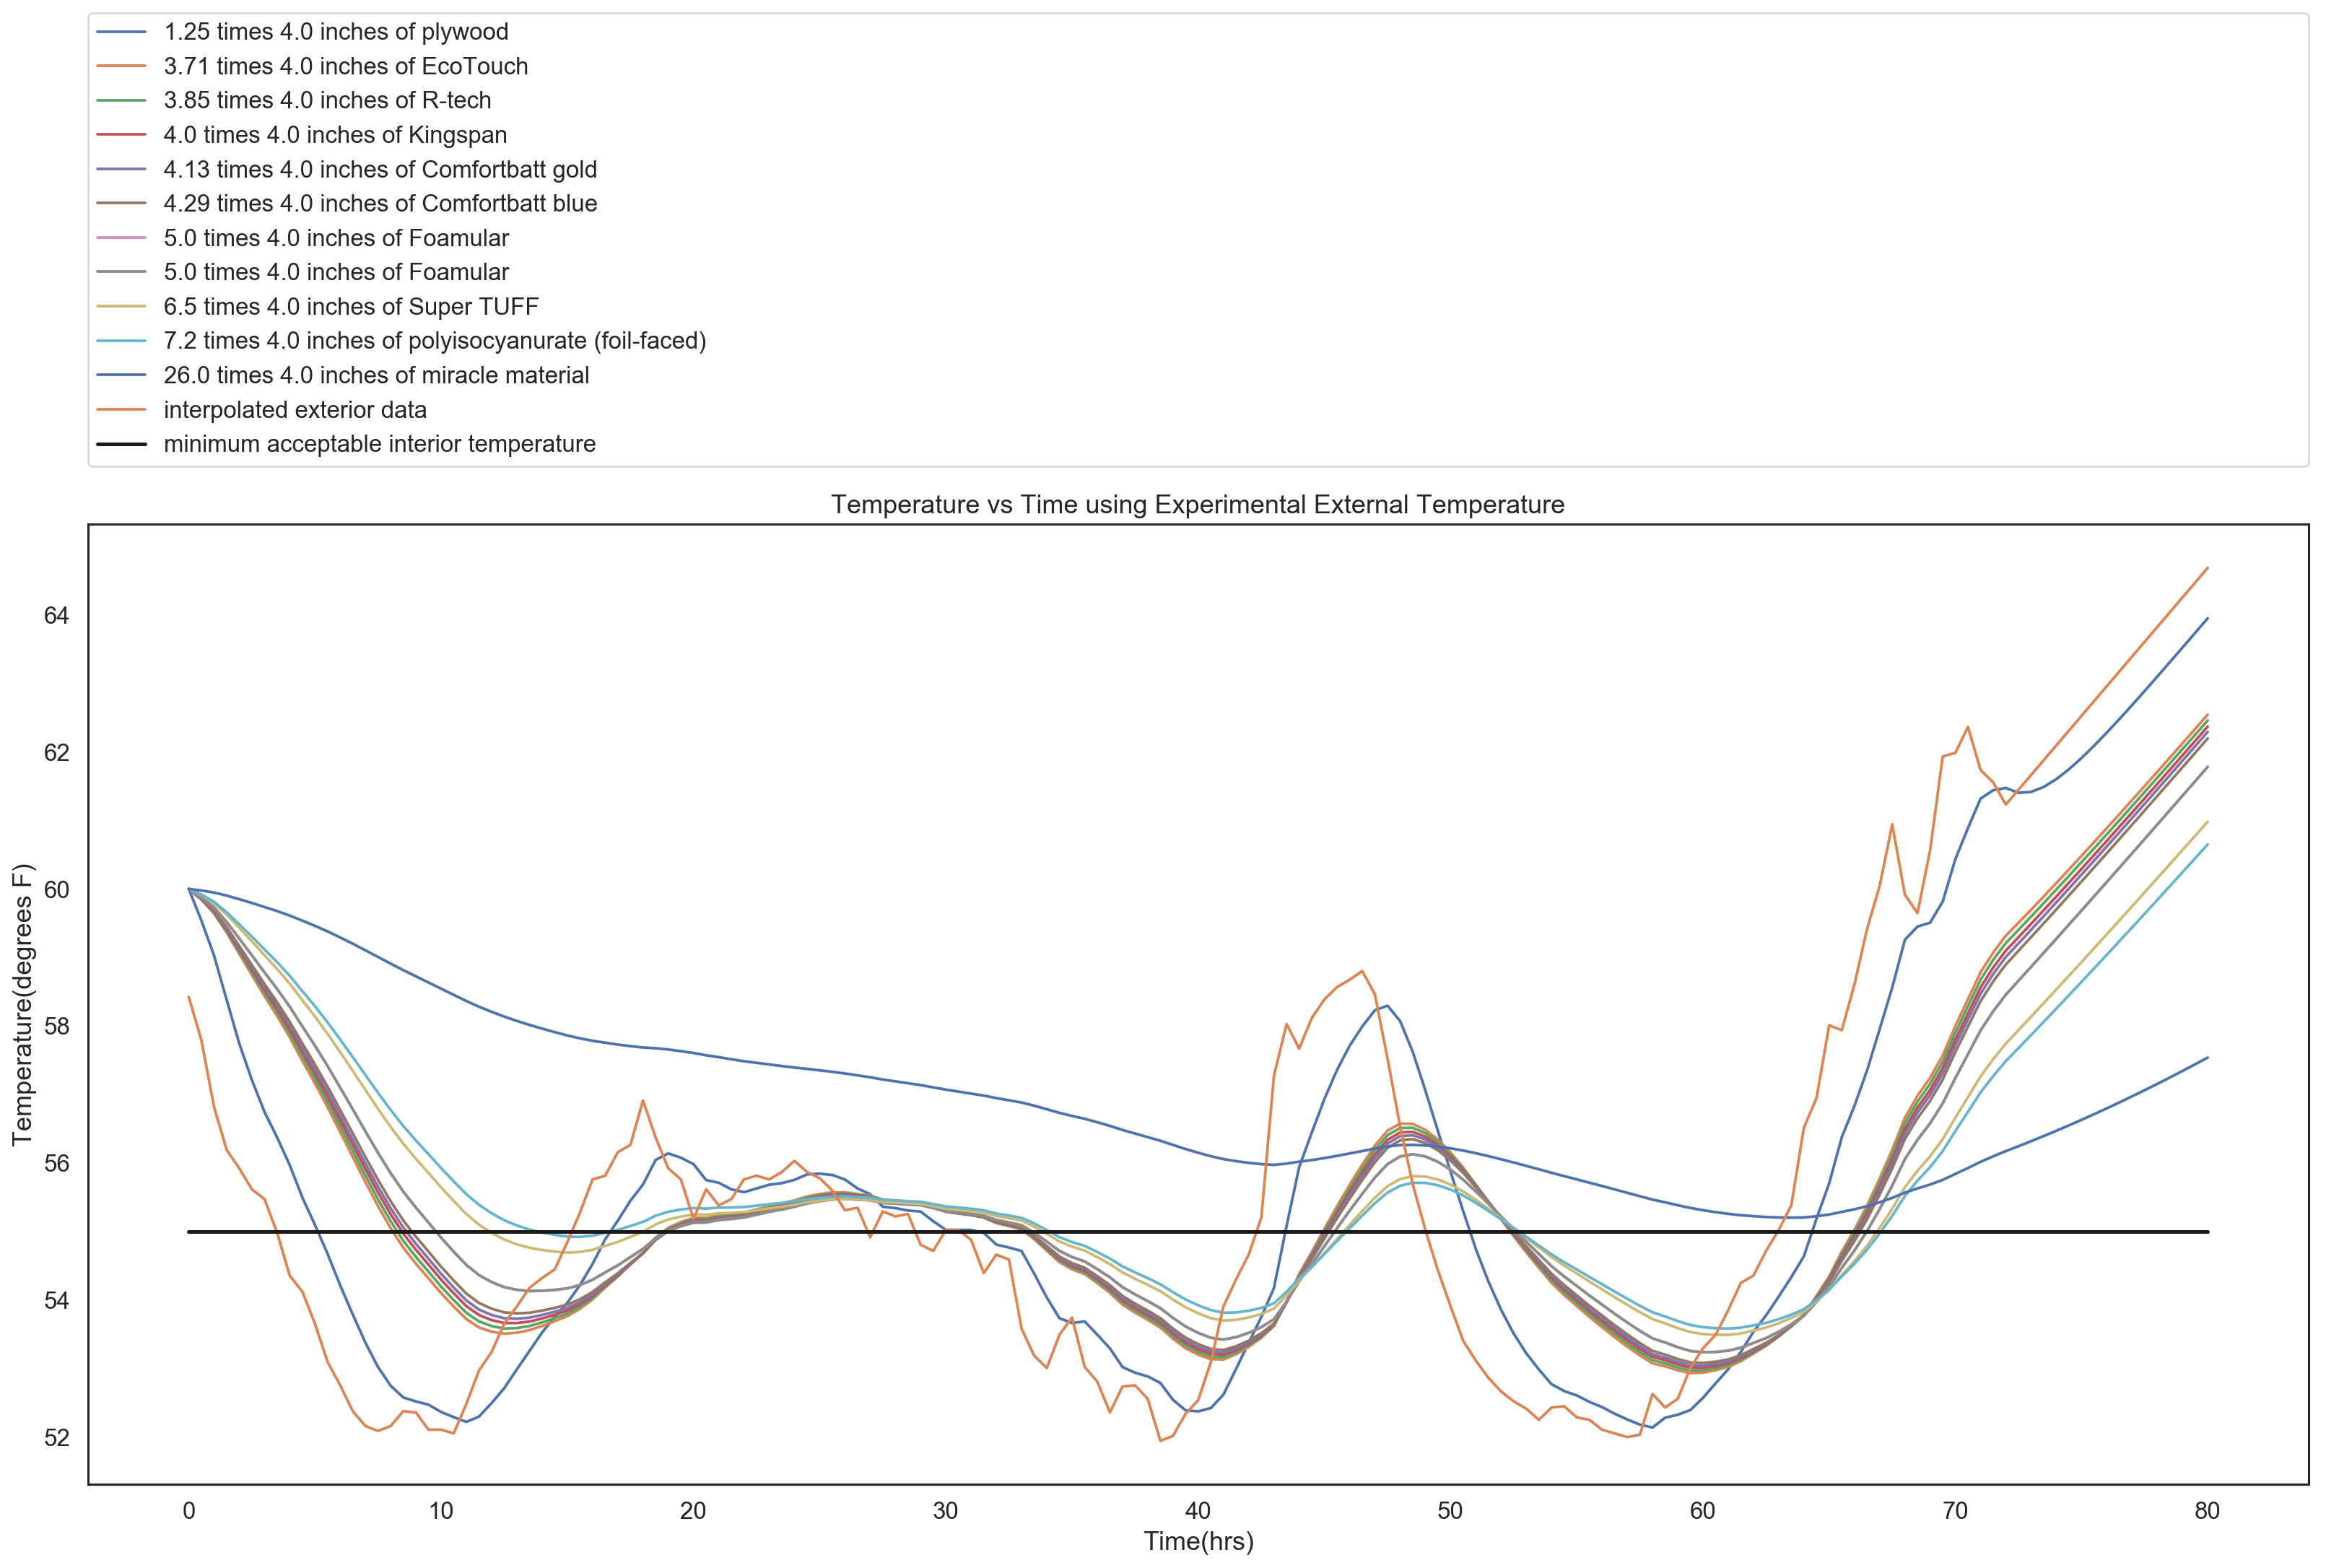

In [502]:
#plot our sweep again
fig_sweep

We plotted temperature over time for several R value simulations to see how different insulation types would hold up over a longer period of time. As expected, those with higher R values fluctuate less with respect to the outside temperature. 